In [1]:
#Miles' packages
from astropy.table import Table
import astropy.coordinates as coord
import glob
from astropy import units as u

#data processing
import pandas as pd
import numpy as np
import math as math
from tqdm import tqdm
import collections

#visualizations
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.use('Agg')
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

#models
from sklearn.cluster import DBSCAN, SpectralClustering
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics.pairwise import pairwise_kernels

#data manipulation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

#for my sanity
import warnings
warnings.filterwarnings('ignore')

In [2]:
!ls '/scratch/bak438/data'

StreamGenerator.ipynb  file_descriptions.txt  gaia_mock_streams  gd1_in_gaia.h5


In [3]:
from astroquery.gaia import Gaia

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [4]:
stream_data_base = '/scratch/bak438/data/gaia_mock_streams/'
stream_files = glob.glob(stream_data_base + 'stream*.fits.gz')

We now have all the stream files:

In [5]:
print(len(stream_files))

for i in range(10):
    table = Table.read(stream_files[i], format='fits')
    stream = table.to_pandas()
    print(len(stream))

322
3133
304
3208
2814
40
1827
1372
578
8226
3374


In [6]:
#relevant cut for each stream
cuts = pd.read_csv('cuts.csv')
print(len(cuts))
cuts.head()

10


,stream_file,ra_min,ra_max,dec_min,dec_max
0,gaia_mock_streams/stream-178.fits.gz,300,350,-10,50
1,gaia_mock_streams/stream-9528.fits.gz,200,350,-70,-30
2,gaia_mock_streams/stream-9549.fits.gz,200,250,-20,40
3,gaia_mock_streams/stream-1954.fits.gz,30,220,-90,-20
4,gaia_mock_streams/stream-2408.fits.gz,180,250,-50,-20


In [7]:
#let us write a function to extract the Gaia noise points based on some inputs
def obtain_noise(min_ra, max_ra, min_dec, max_dec, max_rel_err, n_points):
    
    qry = f" \n\
    select top {n_points} source_id, \n\
    dr2.ra, \n\
    dr2.dec, \n\
    parallax, \n\
    parallax_error, \n\
    pmra, \n\
    pmdec, \n\
    phot_g_mean_mag,\n\
    phot_bp_mean_mag, \n\
    phot_rp_mean_mag, \n\
    bp_rp, \n\
    bp_g, \n\
    g_rp\n\
    from gaiadr2.gaia_source as dr2 \n\
    where dr2.ra > {min_ra} and dr2.ra < {max_ra} and dr2.dec > {min_dec} and dr2.dec < {max_dec} \n\
    and parallax is not null \n\
    and parallax_error is not null \n\
    and abs(dr2.parallax/dr2.parallax_error) < {max_rel_err} \n\
    and pmra is not null \n\
    and pmdec is not null \n\
    and phot_g_mean_mag is not null \n\
    and phot_bp_mean_mag is not null \n\
    and phot_rp_mean_mag is not null \n\
    and bp_rp is not null \n\
    and bp_g is not null \n\
    and g_rp is not null \n\
    order by random_index"

    data_noise = Gaia.launch_job_async(qry).get_results().to_pandas()
    
    return data_noise

In [8]:
table = Table.read(stream_files[0], format='fits')
stream = table.to_pandas()

ra_min = cuts.loc[0].ra_min
ra_max = cuts.loc[0].ra_max
dec_min = cuts.loc[0].dec_min
dec_max = cuts.loc[0].dec_max

#restrict stream to relevant portion
stream = stream.query('ra > ' + str(ra_min) + ' & ra < ' + str(ra_max) + \
                      ' & dec > ' + str(dec_min) + ' & dec < ' + str(dec_max))

#label our data as "part of the stream"
stream['stream_mask'] = True

#split data into training and training data set
print("splitting data")
msk = np.random.rand(len(stream)) < 0.9
stream_train = stream[msk].sample(n = 10)
stream_test = stream[~msk]


#obtain noise points such that:
#- the ratio of stream to noise points in the training set is 2:1 i.e. strong signal
#- the ratio of stream to noise points in the test set is 1:100 i.e. realistic
n_points = 4000 #len(stream_train) // 2 + len(stream_test) * 100

#use max_rel_err of 0.5
max_rel_err =  0.5

#we now select our noise points that we will incorporate into our training and test set
print("obtaining noise")
noise_points = obtain_noise(ra_min, ra_max, dec_min, dec_max, max_rel_err, n_points)

#label our data as "not part of the stream"
noise_points['stream_mask'] = False

splitting data
obtaining noise
INFO: Query finished. [astroquery.utils.tap.core]


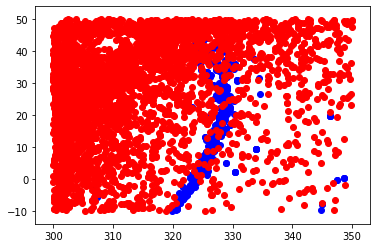

In [9]:
plt.scatter(stream.ra, stream.dec, color = 'b')
plt.scatter(noise_points.ra, noise_points.dec, color = 'r')

In [10]:
def toCartesian(data):
    # Need to know the distance! Can use isochrones to find this. For now, just assume
    # all have the same distance
    N, _ = data.shape
    distance = np.ones(N) #kpc

    # If the parallax is not noisy, you can do distance=1/parallax.

    deg2rad = lambda deg: deg/180.*np.pi

    r = distance
    theta = deg2rad(90 - data['dec'])
    phi = deg2rad(data['ra'])
    ra = deg2rad(data['ra'])
    dec = deg2rad(data['dec'])

    data['x'] = r*np.sin(theta)*np.cos(phi)
    data['y'] = r*np.sin(theta)*np.sin(phi)
    data['z'] = r*np.cos(theta)
    # All of these are in kiloparsecs
    cos = np.cos
    sin = np.sin
    pmra = data['pmra']
    pmdec = data['pmdec']

    data['vx'] = r * (cos(ra)*cos(dec)*pmdec - sin(ra)*sin(dec)*pmra)
    data['vy'] = r * (cos(ra)*sin(dec)*pmra  + cos(dec)*sin(ra)*pmdec)
    data['vz'] = r * (sin(dec)*pmdec)

#### Let us define our potential models here

In [11]:
#let us define a function to run logistic regression on our data set and evaluate the results
def log_reg_model(X_train, X_test, y_train, y_test):
    #do the logistic regression modeling
    log_reg = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000, multi_class='warn').fit(X_train, y_train)
    y_pred = log_reg.predict(X_test)
    y_true = np.array(y_test)
    
    #calculate metrics
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)

    #calculate the AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    auc = metrics.auc(fpr, tpr)
    
    return precision, recall, accuracy, auc

def knn_model(X_train, X_test, y_train, y_test, k):
    #do the KNN modeling
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)
    y_true = np.array(y_test)
    
    #calculate metrics
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)

    #calculate the AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    auc = metrics.auc(fpr, tpr)
    
    return precision, recall, accuracy, auc

def decision_tree_model(X_train, X_test, y_train, y_test):
    #do the KNN modeling
    neigh = DecisionTreeClassifier()
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)
    y_true = np.array(y_test)
    
    #calculate metrics
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)

    #calculate the AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    auc = metrics.auc(fpr, tpr)
    
    return precision, recall, accuracy, auc

def spectral_clustering_model(X_train, X_test, y_train, y_test, affinity = 'rbf'):
    affinity_matrix = pairwise_kernels(X_train, metric = affinity)
    print(affinity_matrix)
    #do the KNN modeling
    sc = SpectralClustering(n_clusters = 2, affinity = 'precomputed')
    y_pred =  sc.fit_predict(abs(affinity_matrix))
    #y_pred = model.labels_
    #print(y_pred)
    #y_pred = neigh.fit_predict(X_test)
    y_true = np.array(y_train)
    #print(len(y_true))
    #calculate metrics
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)

    #calculate the AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    auc = metrics.auc(fpr, tpr)
    
    return precision, recall, accuracy, auc

#### Let us try to perform spectral clustering on the our stellar streams

In [12]:
def get_spectral_metrics(affinity, feature_type='polar'):
    precisions_simulated = []
    recalls_simulated = []
    accuracy_simulated = []
    auc_simulated = []
    print(len(cuts))
    for i in tqdm(range(len(cuts))):
    #for i in tqdm(range(2)):
        table = Table.read(stream_files[i], format='fits')
        stream = table.to_pandas()

        ra_min = cuts.loc[i].ra_min
        ra_max = cuts.loc[i].ra_max
        dec_min = cuts.loc[i].dec_min
        dec_max = cuts.loc[i].dec_max

        #restrict stream to relevant portion
        stream = stream.query('ra > ' + str(ra_min) + ' & ra < ' + \
                              str(ra_max) + ' & dec > ' + str(dec_min) + ' & dec < ' + str(dec_max))

        #label our data as "part of the stream"
        stream['stream_mask'] = True

        #split data into training and training data set
        msk = np.random.rand(len(stream)) < 0.9
        stream_train = stream[msk]
        stream_test = stream[~msk]


        #obtain noise points such that:
        #- the ratio of stream to noise points in the training set is 2:1 i.e. strong signal
        #- the ratio of stream to noise points in the test set is 1:100 i.e. realistic
        n_points = ( len(stream_train) + len(stream_test) ) * 400

        #use max_rel_err of 0.5
        max_rel_err =  0.5

        #we now select our noise points that we will incorporate into our training and test set
        noise_points = obtain_noise(ra_min, ra_max, dec_min, dec_max, max_rel_err, n_points)

        #label our data as "not part of the stream"
        noise_points['stream_mask'] = False

        msk2 = np.random.rand(len(noise_points)) < (len(stream_train) // 2 / n_points)
        noise_train = noise_points[msk2]
        noise_test = noise_points[~msk2]

        #combine my stream and noise to obtain complete training and test data set
        training_data = stream_train.append(noise_train, ignore_index = False, sort = True)
        training_data = training_data[['ra', 'dec', 'pmra', 'pmdec', 'stream_mask']]

        testing_data = stream_test.append(noise_test, ignore_index = False, sort = True)
        testing_data = testing_data[['ra', 'dec', 'pmra', 'pmdec', 'stream_mask']]

        #convert to Cartesian coordinates
        toCartesian(testing_data)
        toCartesian(training_data)

        cartesian_features = ['x', 'y', 'z', 'vx', 'vy', 'vz']
        polar_features = ['ra', 'dec', 'pmra', 'pmdec']
        if feature_type == "polar":
            features = polar_features
        elif feature_type

        #differentiate training and test data's X and y variables
        X_train = training_data[features]
        y_train = training_data.stream_mask

        X_test = testing_data[features]
        y_test = testing_data.stream_mask

        #scale the features using standard scaler (scaling not required for logistic regression)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit(X_train).transform(X_train)
        X_test_scaled = scaler.fit(X_test).transform(X_test)
        #print(y_train)
        X_train.replace([np.inf, -np.inf], np.nan)
        print(np.isinf(X_train.dropna()).all())
        precision, recall, accuracy, auc = \
                spectral_clustering_model(X_train_scaled, X_test, y_train, y_test, affinity = affinity)

        precisions_simulated.append(precision)
        recalls_simulated.append(recall)
        accuracy_simulated.append(accuracy)
        auc_simulated.append(auc)
        
    return precisions_simulated, recalls_simulated, accuracy_simulated, auc_simulated

#### Try running on the training data for different distance metrics

##### Use the polar features to try spectral clustering

In [ ]:
precisions_simulated_lin, recalls_simulated_lin, \
    accuracy_simulated_lin, auc_simulated_lin = get_spectral_metrics('linear')

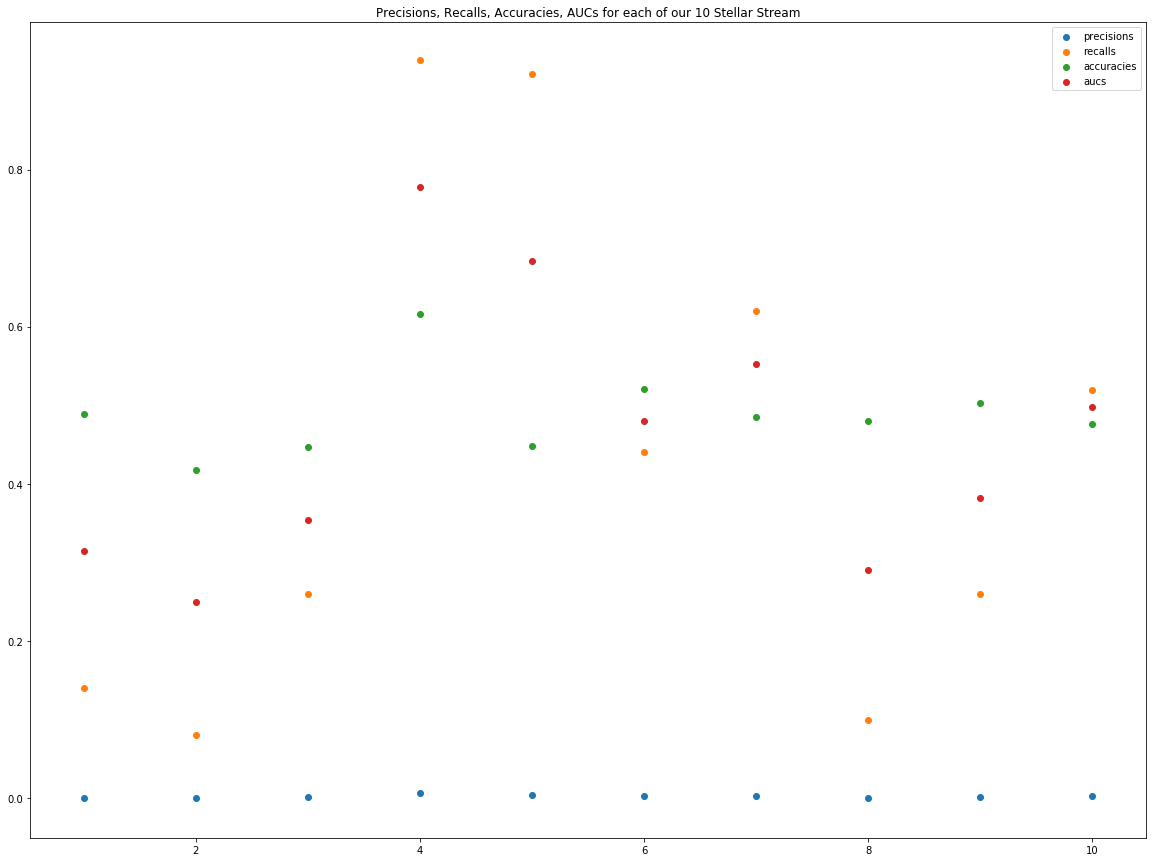

In [10]:
import pickle
import matplotlib.pyplot as plt

affinity = "linear"
with open("accuracy_simulated_" + affinity + ".pickle", "rb") as f:
    accuracy_simulated = pickle.load(f)
with open("auc_simulated_" + affinity + ".pickle", "rb") as f:
    auc_simulated = pickle.load(f)
with open("precisions_simulated_" + affinity + ".pickle", "rb") as f:
    precision_simulated = pickle.load(f)
with open("recalls_simulated_" + affinity + ".pickle", "rb") as f:
    recall_simulated = pickle.load(f)
    
fig = plt.figure(figsize = (20,15))
simulated_streams_index = [i for i in range(1,len(precision_simulated)+1)]
#simulated_streams_index = [i for i in range(1,2+1)]
plt.scatter(simulated_streams_index, precision_simulated, label = 'precisions')
plt.scatter(simulated_streams_index, recall_simulated, label = 'recalls')
plt.scatter(simulated_streams_index, accuracy_simulated, label = 'accuracies')
plt.scatter(simulated_streams_index, auc_simulated, label = 'aucs')
plt.title('Precisions, Recalls, Accuracies, AUCs for each of our ' + str(len(precision_simulated)) + ' Stellar Stream')
plt.legend()

In [ ]:
precisions_simulated_poly, recalls_simulated_poly, \
accuracy_simulated_poly, auc_simulated_poly = get_spectral_metrics('poly')

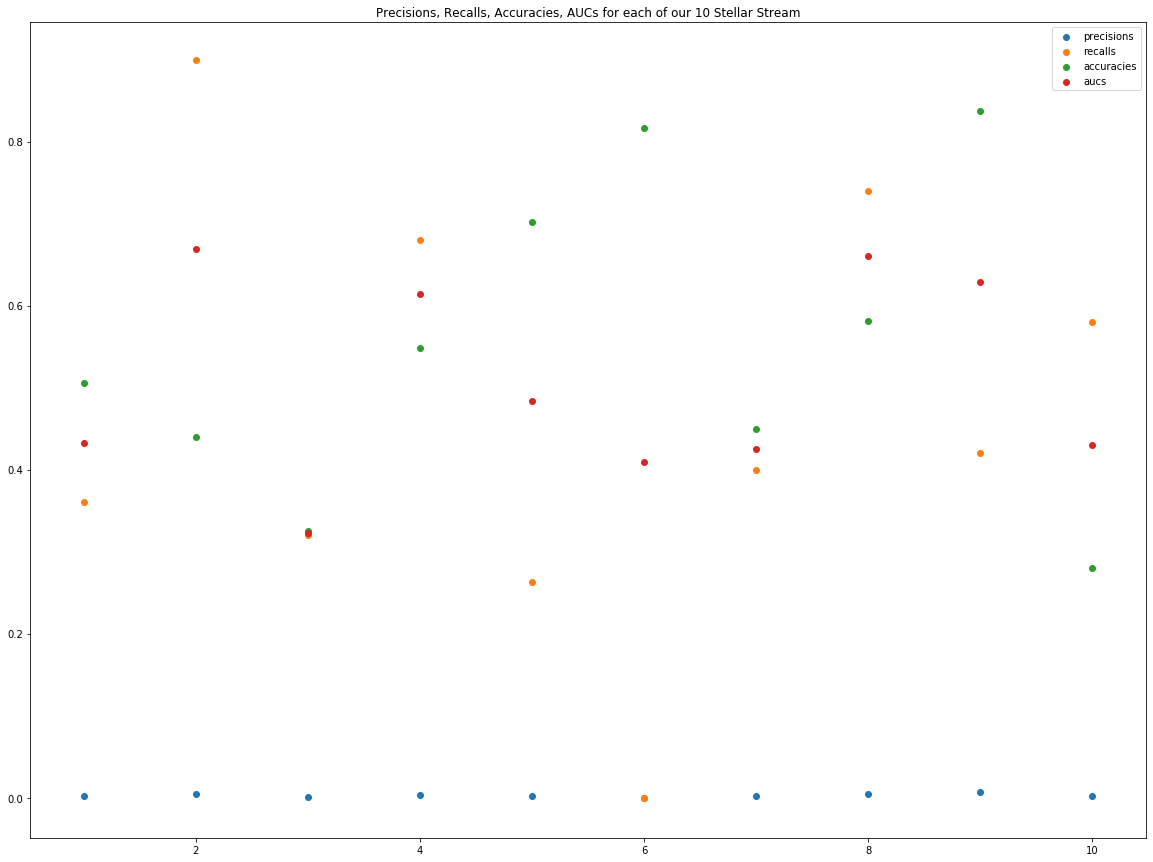

In [11]:
import pickle
import matplotlib.pyplot as plt

affinity = "poly"
with open("accuracy_simulated_" + affinity + ".pickle", "rb") as f:
    accuracy_simulated = pickle.load(f)
with open("auc_simulated_" + affinity + ".pickle", "rb") as f:
    auc_simulated = pickle.load(f)
with open("precisions_simulated_" + affinity + ".pickle", "rb") as f:
    precision_simulated = pickle.load(f)
with open("recalls_simulated_" + affinity + ".pickle", "rb") as f:
    recall_simulated = pickle.load(f)
    
fig = plt.figure(figsize = (20,15))
simulated_streams_index = [i for i in range(1,len(precision_simulated)+1)]
#simulated_streams_index = [i for i in range(1,2+1)]
plt.scatter(simulated_streams_index, precision_simulated, label = 'precisions')
plt.scatter(simulated_streams_index, recall_simulated, label = 'recalls')
plt.scatter(simulated_streams_index, accuracy_simulated, label = 'accuracies')
plt.scatter(simulated_streams_index, auc_simulated, label = 'aucs')
plt.title('Precisions, Recalls, Accuracies, AUCs for each of our ' + str(len(precision_simulated)) + ' Stellar Stream')
plt.legend()

In [ ]:
precisions_simulated_polynomial, recalls_simulated_polynomial, \
accuracy_simulated_polynomial, auc_simulated_polynomial = get_spectral_metrics('polynomial')

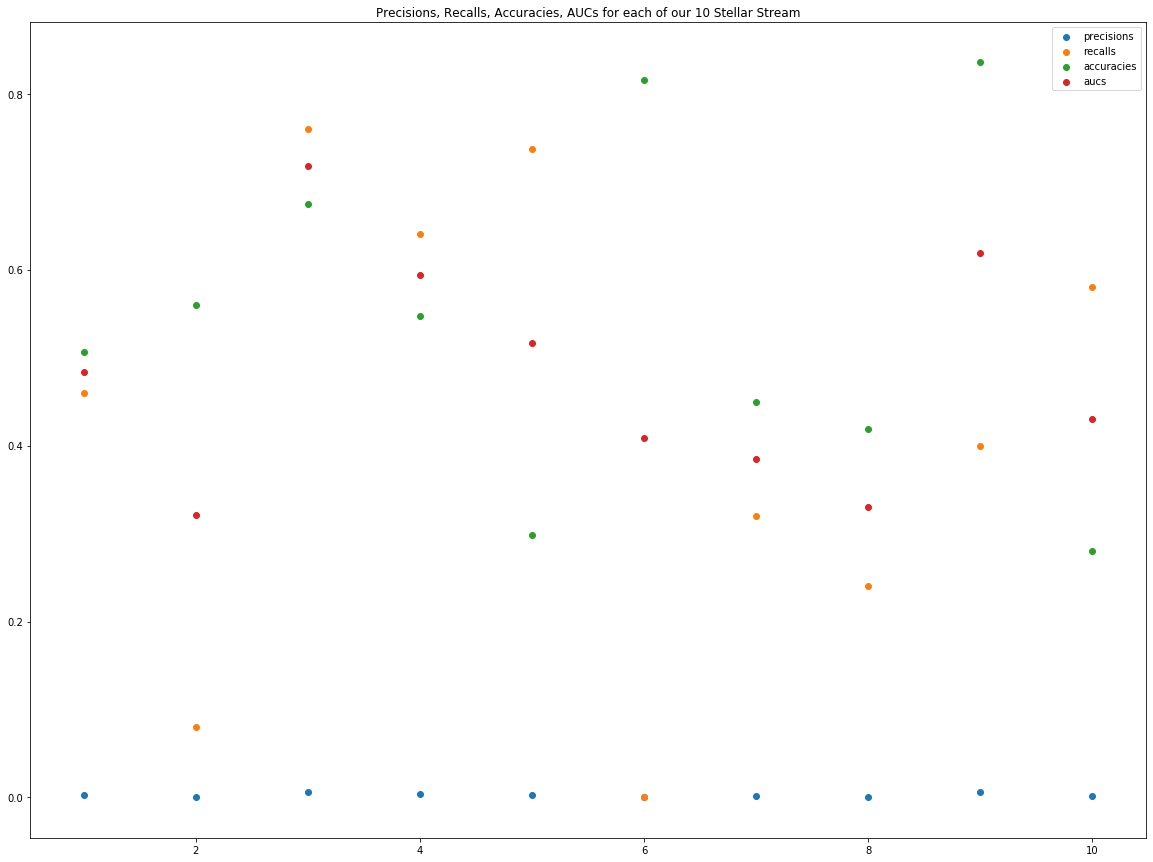

In [12]:
import pickle
import matplotlib.pyplot as plt

affinity = "polynomial"
with open("accuracy_simulated_" + affinity + ".pickle", "rb") as f:
    accuracy_simulated = pickle.load(f)
with open("auc_simulated_" + affinity + ".pickle", "rb") as f:
    auc_simulated = pickle.load(f)
with open("precisions_simulated_" + affinity + ".pickle", "rb") as f:
    precision_simulated = pickle.load(f)
with open("recalls_simulated_" + affinity + ".pickle", "rb") as f:
    recall_simulated = pickle.load(f)
    
fig = plt.figure(figsize = (20,15))
simulated_streams_index = [i for i in range(1,len(precision_simulated)+1)]
#simulated_streams_index = [i for i in range(1,2+1)]
plt.scatter(simulated_streams_index, precision_simulated, label = 'precisions')
plt.scatter(simulated_streams_index, recall_simulated, label = 'recalls')
plt.scatter(simulated_streams_index, accuracy_simulated, label = 'accuracies')
plt.scatter(simulated_streams_index, auc_simulated, label = 'aucs')
plt.title('Precisions, Recalls, Accuracies, AUCs for each of our ' + str(len(precision_simulated)) + ' Stellar Stream')
plt.legend()

In [ ]:
precisions_simulated_rbf, recalls_simulated_rbf, \
accuracy_simulated_rbf, auc_simulated_rbf = get_spectral_metrics('rbf')

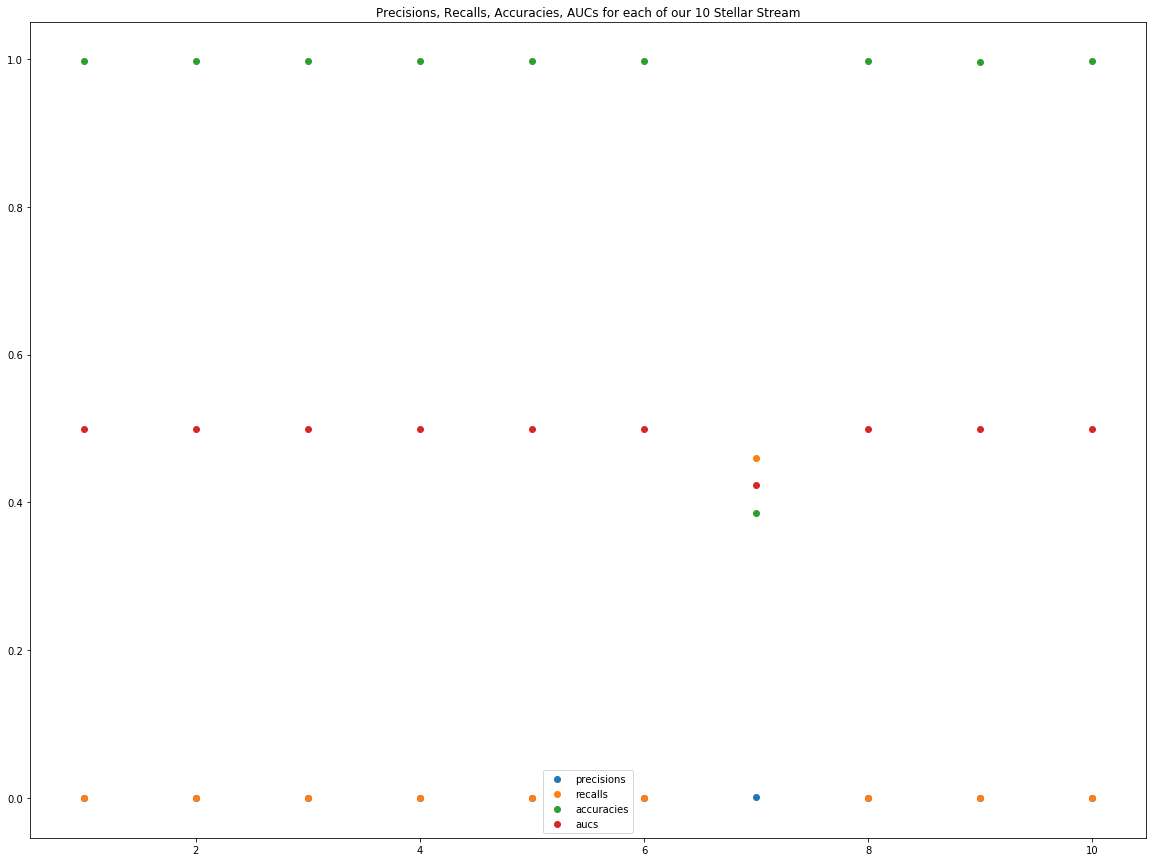

In [13]:
import pickle
import matplotlib.pyplot as plt

affinity = "rbf"
with open("accuracy_simulated_" + affinity + ".pickle", "rb") as f:
    accuracy_simulated = pickle.load(f)
with open("auc_simulated_" + affinity + ".pickle", "rb") as f:
    auc_simulated = pickle.load(f)
with open("precisions_simulated_" + affinity + ".pickle", "rb") as f:
    precision_simulated = pickle.load(f)
with open("recalls_simulated_" + affinity + ".pickle", "rb") as f:
    recall_simulated = pickle.load(f)
    
fig = plt.figure(figsize = (20,15))
simulated_streams_index = [i for i in range(1,len(precision_simulated)+1)]
#simulated_streams_index = [i for i in range(1,2+1)]
plt.scatter(simulated_streams_index, precision_simulated, label = 'precisions')
plt.scatter(simulated_streams_index, recall_simulated, label = 'recalls')
plt.scatter(simulated_streams_index, accuracy_simulated, label = 'accuracies')
plt.scatter(simulated_streams_index, auc_simulated, label = 'aucs')
plt.title('Precisions, Recalls, Accuracies, AUCs for each of our ' + str(len(precision_simulated)) + ' Stellar Stream')
plt.legend()

In [ ]:
precisions_simulated_laplacian, recalls_simulated_laplacian, \
accuracy_simulated_laplacian, auc_simulated_laplacian = get_spectral_metrics('laplacian')

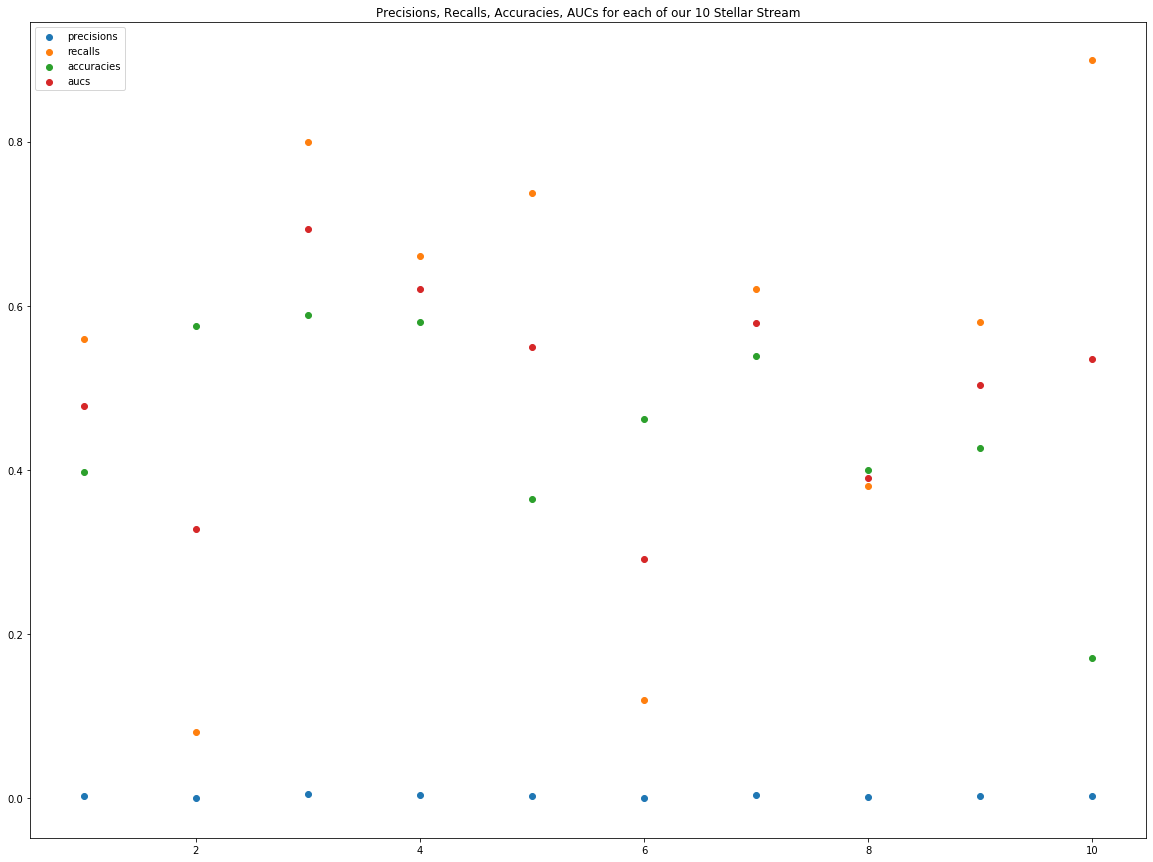

In [14]:
import pickle
import matplotlib.pyplot as plt

affinity = "laplacian"
with open("accuracy_simulated_" + affinity + ".pickle", "rb") as f:
    accuracy_simulated = pickle.load(f)
with open("auc_simulated_" + affinity + ".pickle", "rb") as f:
    auc_simulated = pickle.load(f)
with open("precisions_simulated_" + affinity + ".pickle", "rb") as f:
    precision_simulated = pickle.load(f)
with open("recalls_simulated_" + affinity + ".pickle", "rb") as f:
    recall_simulated = pickle.load(f)
    
fig = plt.figure(figsize = (20,15))
simulated_streams_index = [i for i in range(1,len(precision_simulated)+1)]
#simulated_streams_index = [i for i in range(1,2+1)]
plt.scatter(simulated_streams_index, precision_simulated, label = 'precisions')
plt.scatter(simulated_streams_index, recall_simulated, label = 'recalls')
plt.scatter(simulated_streams_index, accuracy_simulated, label = 'accuracies')
plt.scatter(simulated_streams_index, auc_simulated, label = 'aucs')
plt.title('Precisions, Recalls, Accuracies, AUCs for each of our ' + str(len(precision_simulated)) + ' Stellar Stream')
plt.legend()

In [ ]:
precisions_simulated_sigmoid, recalls_simulated_sigmoid, \
accuracy_simulated_sigmoid, auc_simulated_sigmoid = get_spectral_metrics('sigmoid')

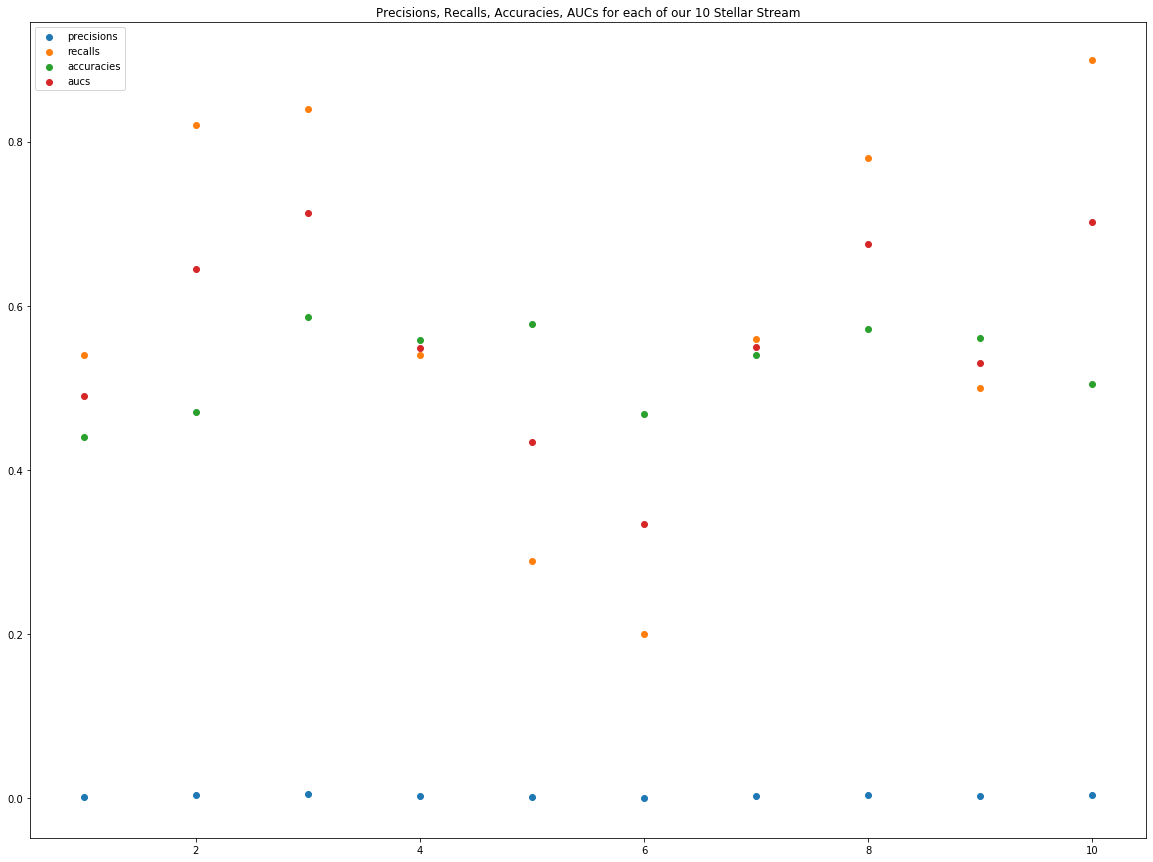

In [15]:
import pickle
import matplotlib.pyplot as plt

affinity = "sigmoid"
with open("accuracy_simulated_" + affinity + ".pickle", "rb") as f:
    accuracy_simulated = pickle.load(f)
with open("auc_simulated_" + affinity + ".pickle", "rb") as f:
    auc_simulated = pickle.load(f)
with open("precisions_simulated_" + affinity + ".pickle", "rb") as f:
    precision_simulated = pickle.load(f)
with open("recalls_simulated_" + affinity + ".pickle", "rb") as f:
    recall_simulated = pickle.load(f)
    
fig = plt.figure(figsize = (20,15))
simulated_streams_index = [i for i in range(1,len(precision_simulated)+1)]
#simulated_streams_index = [i for i in range(1,2+1)]
plt.scatter(simulated_streams_index, precision_simulated, label = 'precisions')
plt.scatter(simulated_streams_index, recall_simulated, label = 'recalls')
plt.scatter(simulated_streams_index, accuracy_simulated, label = 'accuracies')
plt.scatter(simulated_streams_index, auc_simulated, label = 'aucs')
plt.title('Precisions, Recalls, Accuracies, AUCs for each of our ' + str(len(precision_simulated)) + ' Stellar Stream')
plt.legend()

In [ ]:
precisions_simulated_cosine, recalls_simulated_cosine, \
accuracy_simulated_cosine, auc_simlulated_cosine = get_spectral_metrics('cosine')

In [16]:
import pickle
import matplotlib.pyplot as plt

affinity = "cosine"
with open("accuracy_simulated_" + affinity + ".pickle", "rb") as f:
    accuracy_simulated = pickle.load(f)
with open("auc_simulated_" + affinity + ".pickle", "rb") as f:
    auc_simulated = pickle.load(f)
with open("precisions_simulated_" + affinity + ".pickle", "rb") as f:
    precision_simulated = pickle.load(f)
with open("recalls_simulated_" + affinity + ".pickle", "rb") as f:
    recall_simulated = pickle.load(f)
    
fig = plt.figure(figsize = (20,15))
simulated_streams_index = [i for i in range(1,len(precision_simulated)+1)]
#simulated_streams_index = [i for i in range(1,2+1)]
plt.scatter(simulated_streams_index, precision_simulated, label = 'precisions')
plt.scatter(simulated_streams_index, recall_simulated, label = 'recalls')
plt.scatter(simulated_streams_index, accuracy_simulated, label = 'accuracies')
plt.scatter(simulated_streams_index, auc_simulated, label = 'aucs')
plt.title('Precisions, Recalls, Accuracies, AUCs for each of our ' + str(len(precision_simulated)) + ' Stellar Stream')
plt.legend()

FileNotFoundError: [Errno 2] No such file or directory: 'accuracy_simulated_cosine.pickle'